In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer


In [2]:
raw_data = pd.read_csv('mbti_1.csv')
raw_data.head()

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...


In [23]:
df = raw_data
df['text'] = df['posts']
df['label'] = df['type']

In [4]:
def remove_types(text):
    types = ['infj', 'infp', 'intj', 'intp', 'istj', 'istp', 'isfp', 'isfj', 'enfj', 'enfp', 'entj', 'entp', 'estj', 'estp',
       'esfp', 'esfj']
    
    for ptype in types:
        if ptype in text or ptype.upper() in text:
            text = text.replace(ptype, "")
            text = text.replace(ptype+'s', "")
            text = text.replace(ptype+'\'s', "")
            text = text.replace(ptype.upper(), "")
            text = text.replace(ptype.upper()+'s', "")
            text = text.replace(ptype.upper()+'\'s', "")
    
    return text


In [5]:
for index, row in df.iterrows(): 
     df.text[index] = remove_types(df.text[index])

In [6]:
df.head()

,type,posts,text,label
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,INFJ
1,ENTP,'I'm finding the lack of me in these posts ver...,'I'm finding the lack of me in these posts ver...,ENTP
2,INTP,'Good one _____ https://www.youtube.com/wat...,'Good one _____ https://www.youtube.com/wat...,INTP
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...","'Dear , I enjoyed our conversation the other...",INTJ
4,ENTJ,'You're fired.|||That's another silly misconce...,'You're fired.|||That's another silly misconce...,ENTJ


In [24]:
df = df[['text','label']]
df.head()

,text,label
0,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,INFJ
1,'I'm finding the lack of me in these posts ver...,ENTP
2,'Good one _____ https://www.youtube.com/wat...,INTP
3,"'Dear INTP, I enjoyed our conversation the o...",INTJ
4,'You're fired.|||That's another silly misconce...,ENTJ


In [8]:

tfidf = TfidfVectorizer(stop_words='english', sublinear_tf=True, min_df= 50, ngram_range=(1, 3))
features = tfidf.fit_transform(df.text).toarray()
labels = df.label
features.shape

(8675, 12299)

In [9]:
cvec = CountVectorizer(stop_words='english', min_df= 50, ngram_range=(1, 3))
sf = cvec.fit_transform(df.text)

weights = np.asarray(tfidf.fit_transform(df.text).mean(axis=0)).ravel().tolist()
weights_df = pd.DataFrame({'term': cvec.get_feature_names(), 'weight': weights})

weights_df.sort_values(by='weight', ascending=False).head(10)

,term,weight
5912,like,0.034246
5305,just,0.031515
2667,don,0.030380
10623,think,0.029787
7620,people,0.029485
5579,know,0.026789
11506,ve,0.026022
8574,really,0.026011
10880,time,0.023840
1669,com,0.022962


In [10]:
labeled_features = features[labels.notnull()]
labeled_labels = labels[labels.notnull()]

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

models = [
    LogisticRegression(random_state=0,solver='lbfgs',multi_class='auto', max_iter=500),
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
  #  SVC(C = 1, gamma = 1, kernel = 'rbf'),
    MultinomialNB()
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    print(model_name)
    filename = model_name + '.pkl'
    with open(filename, 'wb') as infile:
        pickle.dump(model, infile)
    accuracies = cross_val_score(model, labeled_features, labeled_labels, scoring='accuracy', cv=CV)
    filename = model_name + '.arr'
    with open(filename, 'wb') as infile:
        np.save(infile, accuracies)



LogisticRegression
RandomForestClassifier
MultinomialNB


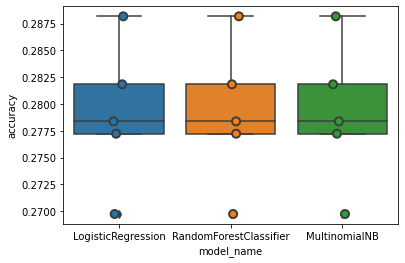

In [13]:

model_names = ['LogisticRegression','RandomForestClassifier','MultinomialNB']

for model_name in model_names:
    
    model = pickle.load(open(model_name + '.pkl', 'rb'))
    accuracy = np.load(model_name+ '.arr')
    
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [14]:
df.head()

,text,label
0,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,INFJ
1,'I'm finding the lack of me in these posts ver...,ENTP
2,'Good one _____ https://www.youtube.com/wat...,INTP
3,"'Dear , I enjoyed our conversation the other...",INTJ
4,'You're fired.|||That's another silly misconce...,ENTJ


In [35]:
df2 = df
df2['ext'] = extraverts.apply(lambda x : 1 if ('E' in x['label']) else 0, axis=1)
df2['int'] = extraverts.apply(lambda x : 1 if ('N' in x['label']) else 0, axis=1)
df2['tnk'] = extraverts.apply(lambda x : 1 if ('T' in x['label']) else 0, axis=1)
df2['jdg'] = extraverts.apply(lambda x : 1 if ('J' in x['label']) else 0, axis=1)

/opt/anaconda3/envs/deep_learning/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [36]:
df2

,text,label,ext,int,tnk,jdg
0,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,INFJ,0,1,0,1
1,'I'm finding the lack of me in these posts ver...,ENTP,1,1,1,0
2,'Good one _____ https://www.youtube.com/wat...,INTP,0,1,1,0
3,"'Dear INTP, I enjoyed our conversation the o...",INTJ,0,1,1,1
4,'You're fired.|||That's another silly misconce...,ENTJ,1,1,1,1
...,...,...,...,...,...,...
8670,'https://www.youtube.com/watch?v=t8edHB_h908||...,ISFP,0,0,0,0
8671,'So...if this thread already exists someplace ...,ENFP,1,1,0,0
8672,'So many questions when i do these things. I ...,INTP,0,1,1,0
8673,'I am very conflicted right now when it comes ...,INFP,0,1,0,0


In [40]:
def run_models(labels, features):
    models = [
    LogisticRegression(random_state=0,solver='lbfgs',multi_class='auto', max_iter=500),
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
  #  SVC(C = 1, gamma = 1, kernel = 'rbf'),
    MultinomialNB()
]
    CV = 5
    cv_df = pd.DataFrame(index=range(CV * len(models)))
    entries = []
    for model in models:
        model_name = model.__class__.__name__
        accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)

        for fold_idx, accuracy in enumerate(accuracies):
            entries.append((model_name, fold_idx, accuracy))
    cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

    sns.boxplot(x='model_name', y='accuracy', data=cv_df)
    sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
                  size=8, jitter=True, edgecolor="gray", linewidth=2)
    plt.show()

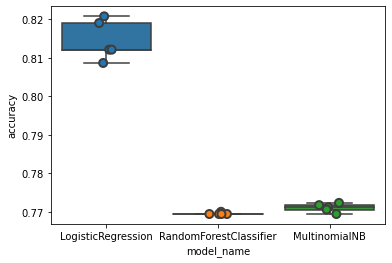

In [47]:
# Extraversion
labels_ext = df2.ext

run_models(labels_ext, features)

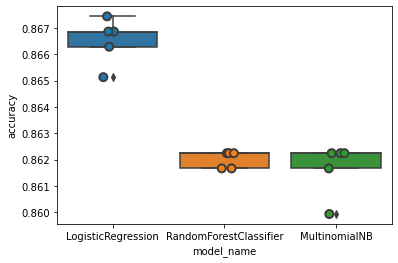

In [48]:
# Intuition
labels_int = df2.int

run_models(labels_int, features)

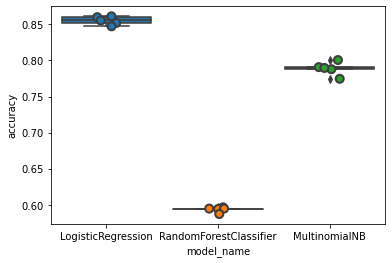

In [71]:
# Thinking
labels_tnk = df2.tnk

run_models(labels_tnk, features)

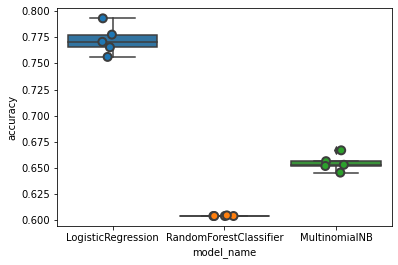

In [72]:
# Judging
labels_jdg = df2.jdg

run_models(labels_jdg, features)

In [74]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train_ext, y_test_ext = train_test_split(features, labels_ext, test_size=0.2, random_state = 28)
X_train, X_test, y_train_int, y_test_int = train_test_split(features, labels_int, test_size=0.2, random_state = 28)
X_train, X_test, y_train_tnk, y_test_tnk = train_test_split(features, labels_tnk, test_size=0.2, random_state = 28)
X_train, X_test, y_train_jdg, y_test_jdg = train_test_split(features, labels_jdg, test_size=0.2, random_state = 28)


In [78]:
lr_ext = LogisticRegression(random_state=0,solver='lbfgs', class_weight="balanced").fit(X_train, y_train_ext)
lr_int = LogisticRegression(random_state=0,solver='lbfgs', class_weight="balanced").fit(X_train, y_train_int)
lr_tnk = LogisticRegression(random_state=0,solver='lbfgs', class_weight="balanced").fit(X_train, y_train_tnk)
lr_jdg = LogisticRegression(random_state=0,solver='lbfgs', class_weight="balanced").fit(X_train, y_train_jdg)
print(lr_ext.score(X_test,y_test_ext))
print(lr_int.score(X_test,y_test_int))
print(lr_tnk.score(X_test,y_test_tnk))
print(lr_jdg.score(X_test,y_test_jdg))

0.8282420749279539
0.8737752161383285
0.8582132564841498
0.8069164265129684


In [79]:
df['ext_pred'] = lr_ext.predict(features)
df['int_pred'] = lr_int.predict(features)
df['tnk_pred'] = lr_int.predict(features)
df['jdg_pred'] = lr_int.predict(features)

In [80]:
df.head()

,text,label,ext,int,tnk,jdg,ext_pred,int_pred,tnk_pred,jdg_pred
0,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,INFJ,0,1,0,1,0,1,1,1
1,'I'm finding the lack of me in these posts ver...,ENTP,1,1,1,0,1,1,1,1
2,'Good one _____ https://www.youtube.com/wat...,INTP,0,1,1,0,0,1,1,1
3,"'Dear INTP, I enjoyed our conversation the o...",INTJ,0,1,1,1,0,1,1,1
4,'You're fired.|||That's another silly misconce...,ENTJ,1,1,1,1,1,1,1,1


In [91]:
def get_label_pred(text):
    if text.ext_pred == 1:
        ext = 'E'
    else:
        ext = 'I'
    if text.int_pred == 1:
        intu = 'N'
    else:
        intu = 'S'
    if text.tnk_pred == 1:
        tnk = 'T'
    else:
        tnk = 'F'
    if text.jdg_pred == 1:
        jdg = 'J'
    else:
        jdg = 'P'
        
    return ext + intu + tnk + jdg

In [92]:
df['label_pred'] = df.apply(get_label_pred, axis=1)

In [93]:
df

,text,label,ext,int,tnk,jdg,ext_pred,int_pred,tnk_pred,jdg_pred,label_pred
0,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,INFJ,0,1,0,1,0,1,1,1,INTJ
1,'I'm finding the lack of me in these posts ver...,ENTP,1,1,1,0,1,1,1,1,ENTJ
2,'Good one _____ https://www.youtube.com/wat...,INTP,0,1,1,0,0,1,1,1,INTJ
3,"'Dear INTP, I enjoyed our conversation the o...",INTJ,0,1,1,1,0,1,1,1,INTJ
4,'You're fired.|||That's another silly misconce...,ENTJ,1,1,1,1,1,1,1,1,ENTJ
...,...,...,...,...,...,...,...,...,...,...,...
8670,'https://www.youtube.com/watch?v=t8edHB_h908||...,ISFP,0,0,0,0,0,0,0,0,ISFP
8671,'So...if this thread already exists someplace ...,ENFP,1,1,0,0,1,1,1,1,ENTJ
8672,'So many questions when i do these things. I ...,INTP,0,1,1,0,0,1,1,1,INTJ
8673,'I am very conflicted right now when it comes ...,INFP,0,1,0,0,0,1,1,1,INTJ


In [94]:
from sklearn.metrics import accuracy_score

accuracy_score(df.label, df.label_pred)

0.1572334293948127